<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn

from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

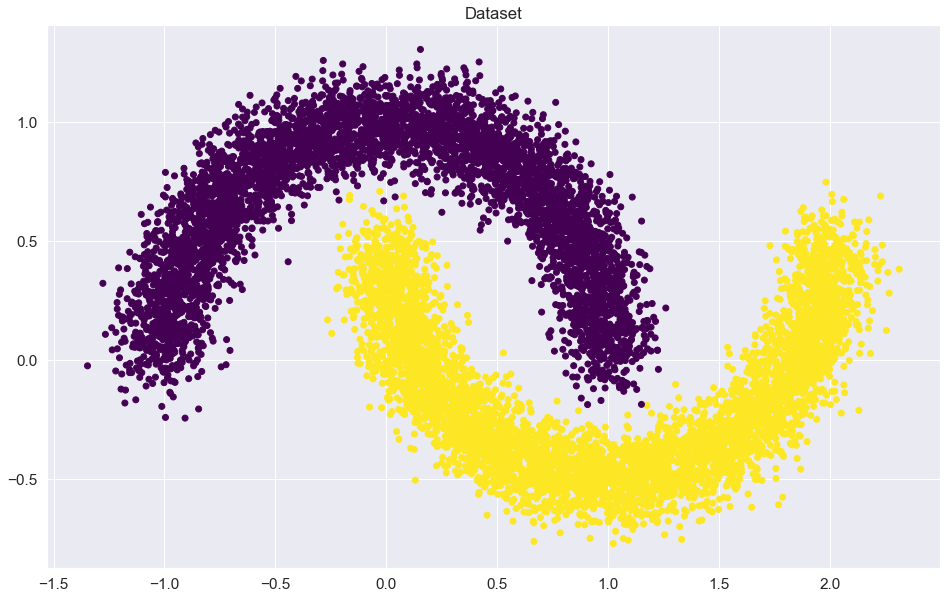

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)
print(y_val.shape)


(2500,)


### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t = torch.from_numpy(X_train).type(torch.float32)# YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train).type(torch.float32) # YOUR CODE GOES HERE
X_val_t = torch.from_numpy(X_val).type(torch.float32) # YOUR CODE GOES HERE
y_val_t = torch.from_numpy(y_val).type(torch.float32) # YOUR CODE GOES HERE



Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
X_train.shape
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 2]), torch.Size([128]))

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        #self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True)).uniform_(-1, 1) / in_features**0.5)
        self.weights = nn.Parameter(torch.randn(in_features, out_features, requires_grad=True))
       
        print(self.weights.shape)
        print(self.weights)
        self.bias = bias
        if bias:
            
            self.bias_term = nn.Parameter(torch.randn(out_features, requires_grad=True))# YOUR CODE GOES HERE
            
            print(self.bias_term.shape)
            print(self.bias_term)

    def forward(self, x):
              
        x =  x @ self.weights# YOUR CODE GOES HERE
        print(x.shape)
        print(x)
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
            
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

     

torch.Size([2, 1])
Parameter containing:
tensor([[-0.0997],
        [-0.9354]], requires_grad=True)
torch.Size([1])
Parameter containing:
tensor([-0.1621], requires_grad=True)


**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
#YOUR CODE веса- w1 и w2 и коэф смещения - b . итого 3 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch.reshape(X_batch.shape[0], -1))# YOUR CODE. Use linear_regression to get outputs
        
        loss = loss_function(outp, y_batch[:, None]) # YOUR CODE. Compute loss
        
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        print(batch_acc)
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
        
    if stop_it:
        break

torch.Size([128, 1])
tensor([[ 0.2657],
        [-0.2216],
        [-0.8161],
        [-0.3829],
        [-0.6965],
        [-0.3466],
        [-0.2420],
        [-0.8302],
        [-0.5949],
        [-0.9534],
        [ 0.2840],
        [-0.2800],
        [ 0.2546],
        [-0.2021],
        [-0.8234],
        [-0.3918],
        [-1.0345],
        [-0.1057],
        [ 0.3631],
        [-0.3045],
        [-0.6303],
        [-0.3188],
        [-0.9795],
        [ 0.4623],
        [-0.7502],
        [-0.6456],
        [-0.4267],
        [ 0.0063],
        [ 0.0191],
        [-0.9789],
        [-1.2126],
        [-1.0431],
        [ 0.4335],
        [-0.0528],
        [-0.4757],
        [-0.5540],
        [-0.3358],
        [-0.9070],
        [-0.6626],
        [-0.4323],
        [ 0.0542],
        [-0.7527],
        [ 0.0120],
        [-0.8556],
        [-0.8967],
        [-0.0961],
        [-0.0299],
        [-0.1459],
        [ 0.1351],
        [-1.0185],
        [ 0.5599],
        [-

prev_weights =  tensor([[ 0.1752],
        [-1.0613]])
torch.Size([128, 1])
tensor([[-1.1094e-01],
        [-2.7425e-01],
        [-1.0564e+00],
        [-6.2832e-01],
        [-1.1324e+00],
        [ 8.1423e-01],
        [ 4.4042e-02],
        [ 2.6615e-02],
        [-7.4393e-01],
        [ 1.5906e-01],
        [-9.2382e-01],
        [ 5.0325e-01],
        [ 7.3529e-01],
        [-5.6174e-01],
        [ 5.9433e-02],
        [ 6.9929e-01],
        [-1.1440e+00],
        [ 7.2894e-01],
        [ 9.3053e-01],
        [-7.2833e-01],
        [ 4.8593e-01],
        [-5.2990e-01],
        [-4.8643e-01],
        [-4.4500e-01],
        [-2.1580e-01],
        [ 7.5138e-01],
        [ 6.9250e-01],
        [-1.6204e-01],
        [ 6.9906e-01],
        [-5.2355e-01],
        [ 6.7367e-01],
        [-7.8467e-02],
        [ 2.7071e-01],
        [-9.5586e-01],
        [-1.1143e+00],
        [-9.3235e-01],
        [ 5.4610e-01],
        [-5.1922e-01],
        [ 7.4361e-01],
        [ 5.7648e-02],
    

tensor(0.5547)
prev_weights =  tensor([[ 0.4050],
        [-1.2082]])
torch.Size([128, 1])
tensor([[ 0.7410],
        [ 0.2521],
        [-0.4332],
        [ 0.4852],
        [-0.8244],
        [-0.3232],
        [-1.1470],
        [ 0.6644],
        [-1.0497],
        [-1.1696],
        [ 0.6019],
        [-0.5296],
        [ 0.8891],
        [ 0.1021],
        [ 0.2683],
        [ 0.5107],
        [-0.2676],
        [ 1.0159],
        [ 0.1395],
        [-0.4648],
        [-1.3926],
        [-0.8673],
        [ 0.6645],
        [-1.0489],
        [ 0.0704],
        [-0.5967],
        [-1.4233],
        [-0.4455],
        [ 0.3749],
        [-1.0904],
        [ 0.0982],
        [ 0.1799],
        [-1.1593],
        [ 1.2493],
        [-1.1124],
        [-0.7596],
        [-1.2354],
        [-1.0071],
        [ 0.4933],
        [-0.5096],
        [ 1.1012],
        [ 1.0763],
        [ 0.9983],
        [-0.9879],
        [-0.8787],
        [-1.2701],
        [-0.7116],
        [ 0.4071

tensor([[-1.2095],
        [ 0.6211],
        [-1.3000],
        [ 0.8122],
        [-1.3455],
        [-1.1155],
        [-1.3398],
        [ 0.1361],
        [-0.9488],
        [-0.7880],
        [ 0.5667],
        [ 0.3152],
        [ 0.4403],
        [-1.1856],
        [ 1.3576],
        [ 0.8850],
        [-0.2427],
        [ 1.0194],
        [-0.6523],
        [-1.3510],
        [-1.1886],
        [-0.5552],
        [ 0.7078],
        [ 0.1798],
        [ 0.3412],
        [-1.0368],
        [ 1.0466],
        [-1.0367],
        [ 1.1848],
        [ 0.3893],
        [-0.4015],
        [-0.2441],
        [-0.3952],
        [ 0.4152],
        [-1.1575],
        [ 0.7783],
        [ 1.3610],
        [ 0.0780],
        [ 1.1833],
        [ 0.8293],
        [-0.8645],
        [-1.5437],
        [ 1.0007],
        [-0.8571],
        [ 0.6265],
        [ 1.0366],
        [-1.3379],
        [-0.7292],
        [-0.9857],
        [ 0.2688],
        [-1.1588],
        [-0.2039],
        [ 0.

tensor(0.5156)
prev_weights =  tensor([[ 0.6817],
        [-1.4504]])
torch.Size([128, 1])
tensor([[ 1.1519],
        [ 0.9016],
        [ 1.1844],
        [-1.4167],
        [-0.8353],
        [ 1.1378],
        [ 1.7085],
        [ 0.7900],
        [-0.7683],
        [ 0.6745],
        [ 0.9046],
        [ 0.6755],
        [ 0.6156],
        [ 0.2565],
        [ 0.0920],
        [ 1.2425],
        [ 1.2738],
        [-0.3103],
        [ 0.8619],
        [-0.8500],
        [-1.4277],
        [ 1.1602],
        [ 0.7535],
        [ 0.7314],
        [ 0.0694],
        [ 0.6348],
        [ 1.3420],
        [-1.5774],
        [-1.3470],
        [-1.6452],
        [-0.1841],
        [ 1.5425],
        [ 1.2224],
        [ 0.5710],
        [ 0.6239],
        [-0.6957],
        [ 0.3580],
        [ 1.6650],
        [ 1.1512],
        [-0.8842],
        [-1.6655],
        [ 1.1127],
        [-0.2287],
        [ 0.6090],
        [ 0.2434],
        [-1.4348],
        [ 1.4972],
        [ 1.5584

tensor(0.5547)
prev_weights =  tensor([[ 0.7918],
        [-1.5756]])
torch.Size([128, 1])
tensor([[-0.9795],
        [-1.2957],
        [-1.0913],
        [-1.4680],
        [-0.1569],
        [-1.0438],
        [-1.5834],
        [-1.2957],
        [-1.6838],
        [-1.7110],
        [ 1.0011],
        [-1.0983],
        [-1.0152],
        [-0.1548],
        [ 0.3987],
        [ 0.2423],
        [ 1.8614],
        [ 1.6331],
        [-1.3956],
        [ 0.2417],
        [ 1.2470],
        [ 1.7165],
        [ 0.6149],
        [ 0.4529],
        [ 0.9067],
        [ 1.7481],
        [ 1.0063],
        [-0.5139],
        [-1.4306],
        [ 1.0376],
        [ 1.6006],
        [-1.5466],
        [ 1.3998],
        [ 1.9634],
        [ 0.9362],
        [-1.6563],
        [-1.4317],
        [ 1.4943],
        [ 1.1351],
        [-0.9396],
        [-1.5903],
        [ 1.2782],
        [ 1.4121],
        [-0.0726],
        [ 1.6835],
        [-1.4413],
        [ 0.8789],
        [ 1.3588

tensor([[-0.5816],
        [-0.7978],
        [-1.2021],
        [-1.6712],
        [-1.0916],
        [ 0.1197],
        [-1.0487],
        [-1.3945],
        [ 1.1069],
        [-1.9055],
        [ 0.5857],
        [ 0.8576],
        [-0.3810],
        [ 2.1687],
        [-0.4247],
        [-1.6280],
        [ 0.4873],
        [ 0.3851],
        [-1.1675],
        [-1.8499],
        [ 1.2973],
        [-0.1050],
        [-1.4720],
        [ 1.5756],
        [-0.8621],
        [ 1.9111],
        [-1.5599],
        [-1.1177],
        [ 0.1859],
        [-0.6273],
        [-0.8155],
        [ 0.5670],
        [-1.5463],
        [-0.5754],
        [ 0.9199],
        [ 0.3234],
        [ 1.3050],
        [ 0.2233],
        [ 0.0953],
        [ 1.5725],
        [ 0.8469],
        [ 0.4521],
        [ 1.5532],
        [ 0.9069],
        [ 1.8367],
        [-1.9794],
        [ 0.2186],
        [ 0.9946],
        [-0.7292],
        [ 0.1168],
        [ 1.6855],
        [-1.2967],
        [ 1.

prev_weights =  tensor([[ 0.8952],
        [-1.7329]])
torch.Size([128, 1])
tensor([[ 2.1602],
        [-0.3353],
        [-1.6710],
        [-1.0832],
        [-1.6020],
        [-0.1304],
        [ 2.1689],
        [-0.6314],
        [-1.6091],
        [ 1.2347],
        [-0.3855],
        [-0.0364],
        [ 0.2347],
        [-0.9946],
        [-1.9356],
        [-1.0491],
        [-0.7279],
        [ 1.9798],
        [ 1.8758],
        [-1.6212],
        [-1.7750],
        [-1.8507],
        [ 1.0728],
        [ 2.2099],
        [-1.7116],
        [ 0.7628],
        [ 1.5222],
        [-1.3030],
        [ 1.8637],
        [-1.3664],
        [ 1.8711],
        [-1.9142],
        [ 1.2096],
        [-1.1497],
        [-0.7523],
        [ 1.4051],
        [-1.1318],
        [-0.6782],
        [ 1.6929],
        [-1.6136],
        [ 0.0452],
        [ 1.3544],
        [-1.2095],
        [ 1.2302],
        [ 1.8721],
        [-0.9862],
        [-1.4244],
        [ 1.9843],
        [-1.

prev_weights =  tensor([[ 0.9313],
        [-1.7914]])
torch.Size([128, 1])
tensor([[-1.5794],
        [ 1.5324],
        [-1.5874],
        [ 1.4391],
        [-2.2884],
        [ 0.9221],
        [-0.0494],
        [ 2.1390],
        [-2.1268],
        [-1.1988],
        [ 1.2824],
        [ 0.6294],
        [-2.0611],
        [-1.0407],
        [-1.4109],
        [ 1.5068],
        [ 0.6234],
        [-0.4907],
        [-2.0126],
        [-1.8438],
        [-0.7580],
        [ 1.1164],
        [ 1.8135],
        [-1.8967],
        [-2.0638],
        [-0.7790],
        [-0.4620],
        [ 1.8642],
        [ 1.5510],
        [ 1.9155],
        [ 1.1063],
        [-2.0862],
        [-0.0235],
        [ 0.6805],
        [-2.0585],
        [-1.7865],
        [ 0.4338],
        [-1.6591],
        [ 2.0455],
        [ 1.9406],
        [-0.1875],
        [ 0.2309],
        [ 1.7859],
        [ 1.3007],
        [-1.9214],
        [ 0.5507],
        [-2.1724],
        [ 2.1356],
        [ 1.

tensor(0.5469)
prev_weights =  tensor([[ 0.9756],
        [-1.8831]])
torch.Size([128, 1])
tensor([[-1.4951],
        [ 1.7170],
        [ 1.7128],
        [ 1.4627],
        [-2.2567],
        [ 0.9032],
        [ 2.1501],
        [-2.1204],
        [ 0.3767],
        [ 1.4534],
        [ 2.1202],
        [-0.7594],
        [-1.6662],
        [ 1.1429],
        [-2.1167],
        [-1.7552],
        [-2.0396],
        [-2.1399],
        [-2.6455],
        [-1.5073],
        [ 1.4696],
        [-0.4612],
        [ 1.1010],
        [-1.9925],
        [ 1.9610],
        [-1.5772],
        [ 0.1362],
        [ 1.2486],
        [ 0.4111],
        [-2.1929],
        [ 1.3954],
        [-2.2883],
        [-0.8235],
        [ 0.2119],
        [ 2.2166],
        [ 1.2777],
        [ 0.1415],
        [-2.2086],
        [ 0.1299],
        [ 1.2736],
        [-1.9787],
        [-1.0459],
        [ 2.1784],
        [ 0.9246],
        [ 2.1493],
        [-0.2591],
        [ 1.9826],
        [-1.6996

prev_weights =  tensor([[ 1.0031],
        [-1.9417]])
torch.Size([128, 1])
tensor([[ 0.3106],
        [ 2.2285],
        [-0.8929],
        [ 2.2597],
        [ 1.5857],
        [ 0.8350],
        [-2.4113],
        [-2.1677],
        [ 2.1361],
        [-0.9663],
        [ 0.1077],
        [-0.5823],
        [-1.7935],
        [-1.1206],
        [-0.2797],
        [ 1.8307],
        [ 1.9769],
        [-1.7860],
        [-2.0615],
        [-1.7219],
        [ 0.5556],
        [-2.0692],
        [-0.1368],
        [-1.5775],
        [ 2.1804],
        [-1.0254],
        [ 1.9728],
        [-1.8268],
        [ 0.6388],
        [ 2.0191],
        [ 1.7092],
        [-2.3508],
        [-0.0737],
        [ 2.0608],
        [ 0.8217],
        [-1.5732],
        [-1.3838],
        [-1.1497],
        [-1.1401],
        [-0.0783],
        [-2.0975],
        [-2.3919],
        [-2.4161],
        [-2.2614],
        [ 0.8035],
        [ 2.5547],
        [ 0.5343],
        [-0.6798],
        [-1.

tensor(0.5312)
prev_weights =  tensor([[ 1.0436],
        [-2.0218]])
torch.Size([128, 1])
tensor([[ 2.3447],
        [ 0.1574],
        [-2.2950],
        [ 0.7602],
        [-1.5071],
        [-0.6532],
        [-0.6401],
        [ 1.8075],
        [ 2.5624],
        [ 1.8206],
        [-1.4803],
        [ 2.4781],
        [ 1.9580],
        [-2.1191],
        [-2.3680],
        [ 2.5416],
        [-2.2606],
        [ 2.4205],
        [ 0.8878],
        [-0.2003],
        [-1.3082],
        [-1.7555],
        [-1.9898],
        [ 1.0688],
        [ 2.0651],
        [ 0.9848],
        [ 1.0406],
        [-1.5053],
        [-1.2674],
        [ 1.8356],
        [ 2.0624],
        [-1.6347],
        [-2.3000],
        [ 1.3497],
        [ 2.2204],
        [ 2.0034],
        [ 1.9101],
        [-1.7401],
        [ 1.3086],
        [-2.2195],
        [ 0.4095],
        [ 2.6057],
        [-0.7020],
        [-2.1926],
        [ 1.2382],
        [ 1.4626],
        [ 1.3182],
        [ 0.3543

tensor(0.5547)
prev_weights =  tensor([[ 1.0560],
        [-2.0694]])
torch.Size([128, 1])
tensor([[ 2.7624],
        [ 0.3078],
        [ 0.7046],
        [ 2.5142],
        [-0.0145],
        [ 0.9448],
        [-1.9761],
        [ 0.9526],
        [-1.3283],
        [ 2.2140],
        [-1.9402],
        [-2.0266],
        [-1.0940],
        [-1.0842],
        [ 2.1962],
        [-1.7048],
        [ 2.2808],
        [ 0.2625],
        [ 2.3442],
        [-2.3035],
        [ 2.8824],
        [-2.1269],
        [ 2.4382],
        [-1.4059],
        [-2.2064],
        [ 2.2224],
        [ 0.1569],
        [ 2.0238],
        [-2.4086],
        [ 0.3485],
        [ 2.0843],
        [-2.4037],
        [ 2.0065],
        [-2.4037],
        [-0.9858],
        [-1.6364],
        [ 2.0147],
        [-2.2267],
        [-1.8956],
        [ 2.3554],
        [ 1.9041],
        [ 1.6680],
        [ 2.3743],
        [-2.2565],
        [-0.0577],
        [-1.1105],
        [-2.5885],
        [ 0.3261

torch.Size([128, 1])
tensor([[ 2.6603],
        [-0.5992],
        [-0.1084],
        [-0.4284],
        [ 2.3589],
        [-0.6218],
        [ 0.6526],
        [ 1.4040],
        [-0.0653],
        [ 2.7716],
        [ 2.3988],
        [ 2.4709],
        [-2.2406],
        [-1.3652],
        [-0.1499],
        [ 0.9470],
        [ 2.1085],
        [-1.5480],
        [ 1.8834],
        [-1.7843],
        [ 1.7245],
        [ 2.6024],
        [-1.8171],
        [-1.9305],
        [ 0.5466],
        [-0.8560],
        [ 2.5757],
        [ 0.8834],
        [ 0.6611],
        [ 2.4059],
        [-2.3798],
        [-1.0511],
        [-1.5371],
        [-0.2678],
        [ 1.9845],
        [ 2.3184],
        [-0.0195],
        [ 0.7192],
        [-0.2931],
        [-0.9648],
        [-0.8919],
        [-2.4939],
        [ 2.1303],
        [-2.4836],
        [ 0.3123],
        [ 1.7935],
        [-2.1575],
        [-2.1311],
        [ 1.8038],
        [ 1.7419],
        [ 1.2360],
        [ 

tensor([[-1.4058],
        [-0.0429],
        [ 1.1117],
        [-2.3124],
        [ 1.7232],
        [-1.4406],
        [-1.8629],
        [ 2.2229],
        [-1.2992],
        [-1.9712],
        [ 0.9691],
        [-2.2634],
        [-0.5807],
        [-2.0969],
        [ 2.0392],
        [-2.8613],
        [ 2.4438],
        [ 1.6411],
        [-1.8768],
        [-2.0145],
        [-1.6997],
        [ 2.0830],
        [ 2.1782],
        [-2.1200],
        [ 2.4009],
        [ 0.5095],
        [ 2.1734],
        [-1.8146],
        [-1.3807],
        [-1.3305],
        [ 2.4798],
        [ 0.8409],
        [ 0.7198],
        [-0.8357],
        [ 0.5942],
        [ 0.1044],
        [-2.2860],
        [ 2.1197],
        [-2.3484],
        [ 1.8901],
        [ 2.3706],
        [ 2.3296],
        [ 0.7119],
        [-2.1412],
        [-0.0572],
        [ 2.4080],
        [-1.4545],
        [-0.6026],
        [ 1.8785],
        [-2.3920],
        [ 2.5948],
        [-0.2525],
        [-2.

prev_weights =  tensor([[ 1.0909],
        [-2.1608]])
torch.Size([128, 1])
tensor([[-0.8983],
        [ 1.2876],
        [-2.3388],
        [ 1.0858],
        [-0.9990],
        [-1.5954],
        [ 2.3706],
        [ 2.1279],
        [-2.1754],
        [-1.1676],
        [ 0.5065],
        [-2.1671],
        [ 1.8209],
        [ 1.5327],
        [-1.0913],
        [ 0.9306],
        [ 0.9908],
        [ 1.8646],
        [ 2.2637],
        [-0.3209],
        [-1.6018],
        [-2.4665],
        [ 2.5656],
        [-2.3912],
        [-2.1457],
        [ 2.4440],
        [-1.8522],
        [-1.2503],
        [-0.9975],
        [ 2.1953],
        [-2.0765],
        [ 0.3587],
        [ 1.2304],
        [ 2.3035],
        [ 1.8505],
        [ 1.5718],
        [-0.3345],
        [-1.2259],
        [ 1.5531],
        [ 0.6483],
        [ 1.1118],
        [-2.2145],
        [-2.2891],
        [ 2.3130],
        [ 2.3857],
        [-1.2864],
        [-1.6937],
        [ 2.2076],
        [-1.

tensor(0.4297)
prev_weights =  tensor([[ 1.1036],
        [-2.1986]])
torch.Size([128, 1])
tensor([[ 1.8086],
        [ 1.6699],
        [-2.0710],
        [ 2.3475],
        [-1.4899],
        [ 1.4008],
        [ 2.1198],
        [ 1.5291],
        [ 2.2515],
        [-0.7538],
        [-0.7768],
        [ 2.1040],
        [ 1.3497],
        [-0.7904],
        [-2.7826],
        [-1.2900],
        [-2.4262],
        [ 0.8716],
        [ 0.9470],
        [-1.1451],
        [-0.8888],
        [ 0.2567],
        [ 0.3545],
        [-2.3503],
        [-0.0590],
        [ 2.0077],
        [-1.8634],
        [ 1.7309],
        [ 1.9695],
        [ 0.0055],
        [-2.3183],
        [ 1.5600],
        [ 2.1352],
        [-2.5106],
        [-0.4350],
        [ 0.7792],
        [-1.4500],
        [ 0.3648],
        [-2.4150],
        [-2.1104],
        [-1.7802],
        [ 2.2401],
        [-2.2345],
        [ 2.6624],
        [-2.1615],
        [-2.6398],
        [-0.3728],
        [-0.1974

tensor([[ 1.3190],
        [-0.5594],
        [-1.1863],
        [-2.2186],
        [-2.7688],
        [ 0.4742],
        [ 1.0124],
        [-2.2301],
        [ 1.3049],
        [-2.2754],
        [ 1.3881],
        [ 0.6925],
        [ 2.7376],
        [-1.7472],
        [-1.0285],
        [ 0.4939],
        [-2.5608],
        [-0.0280],
        [ 1.7868],
        [-2.0156],
        [-1.7366],
        [ 1.7849],
        [-1.9213],
        [ 1.9614],
        [ 0.7570],
        [-0.1641],
        [ 1.8107],
        [ 0.1694],
        [ 2.5376],
        [-1.8470],
        [-2.3438],
        [-2.9691],
        [ 2.9138],
        [-0.1868],
        [-2.3356],
        [-2.5850],
        [ 0.3112],
        [-2.4946],
        [-2.8280],
        [ 0.0497],
        [ 2.4156],
        [-2.2677],
        [-1.6244],
        [-2.0342],
        [-1.9831],
        [ 2.2888],
        [ 1.9829],
        [-1.6687],
        [ 0.7947],
        [-2.3943],
        [ 3.0473],
        [ 0.6058],
        [ 1.

torch.Size([128, 1])
tensor([[ 1.5520],
        [-2.2497],
        [ 2.3335],
        [-0.2691],
        [ 2.5745],
        [ 2.1858],
        [-0.6142],
        [-1.9182],
        [ 1.9278],
        [-2.1876],
        [-3.0081],
        [ 0.6635],
        [ 2.6553],
        [ 1.5175],
        [ 1.4564],
        [-2.4995],
        [ 2.3357],
        [ 0.7538],
        [ 1.9494],
        [-2.4806],
        [-0.4475],
        [ 0.0184],
        [-2.2787],
        [ 2.0883],
        [ 0.9807],
        [ 2.2792],
        [ 0.3821],
        [ 2.6428],
        [-2.6306],
        [ 0.6022],
        [ 0.9437],
        [ 2.5511],
        [-0.7707],
        [-0.1983],
        [ 2.3479],
        [-0.6932],
        [ 2.2288],
        [-1.1505],
        [ 0.2864],
        [-1.9427],
        [-0.7203],
        [ 2.6245],
        [-1.7694],
        [-2.2893],
        [-1.3918],
        [-2.2960],
        [-2.0363],
        [ 2.3153],
        [-2.6786],
        [ 2.3450],
        [-0.4606],
        [ 

tensor(0.4688)
prev_weights =  tensor([[ 1.1379],
        [-2.3172]])
torch.Size([128, 1])
tensor([[ 1.9641],
        [-1.0563],
        [ 1.1664],
        [-2.8938],
        [ 2.7993],
        [ 0.7728],
        [-2.2536],
        [-1.1909],
        [ 0.9002],
        [-2.3559],
        [ 1.1577],
        [ 1.6330],
        [ 2.1225],
        [ 0.8891],
        [ 1.3040],
        [-1.2033],
        [-0.8957],
        [ 0.6549],
        [-2.5647],
        [ 2.9096],
        [-0.0268],
        [-1.0316],
        [-0.3660],
        [-0.1483],
        [ 1.4057],
        [ 2.7989],
        [ 2.3605],
        [ 2.3521],
        [-2.0562],
        [ 0.2252],
        [ 1.8784],
        [ 2.2165],
        [ 1.9457],
        [-1.8157],
        [-2.4052],
        [-0.4503],
        [-0.8857],
        [-0.0208],
        [ 1.9801],
        [ 2.7530],
        [ 1.6705],
        [ 2.3991],
        [ 2.6301],
        [ 0.6726],
        [-0.6295],
        [ 0.3553],
        [ 1.5595],
        [ 0.7961

torch.Size([128, 1])
tensor([[ 1.9392],
        [ 1.5385],
        [ 1.9490],
        [-2.3361],
        [-1.3972],
        [ 1.9311],
        [ 2.8300],
        [ 1.2981],
        [-1.2310],
        [ 1.1149],
        [ 1.4952],
        [ 1.1132],
        [ 1.0711],
        [ 0.4223],
        [ 0.1504],
        [ 2.0512],
        [ 2.0985],
        [-0.4704],
        [ 1.4679],
        [-1.3630],
        [-2.3371],
        [ 1.9459],
        [ 1.2435],
        [ 1.2290],
        [ 0.1194],
        [ 1.0692],
        [ 2.2475],
        [-2.5695],
        [-2.2076],
        [-2.6982],
        [-0.2966],
        [ 2.5487],
        [ 2.0471],
        [ 0.9591],
        [ 1.0859],
        [-1.1651],
        [ 0.6188],
        [ 2.7641],
        [ 1.8925],
        [-1.4851],
        [-2.7296],
        [ 1.8266],
        [-0.3710],
        [ 1.0005],
        [ 0.4019],
        [-2.3329],
        [ 2.4676],
        [ 2.5728],
        [ 1.9781],
        [-0.7710],
        [ 2.2797],
        [-

tensor(0.4297)
prev_weights =  tensor([[ 1.1508],
        [-2.3929]])
torch.Size([128, 1])
tensor([[ 2.9105],
        [-0.7226],
        [-0.1802],
        [-0.4842],
        [ 2.6079],
        [-0.7475],
        [ 0.6802],
        [ 1.5657],
        [-0.0694],
        [ 3.0550],
        [ 2.6358],
        [ 2.7403],
        [-2.5193],
        [-1.5585],
        [-0.2176],
        [ 0.9542],
        [ 2.2923],
        [-1.7629],
        [ 2.0156],
        [-1.9826],
        [ 1.8321],
        [ 2.8763],
        [-2.0675],
        [-2.2046],
        [ 0.6044],
        [-0.9679],
        [ 2.8164],
        [ 0.9679],
        [ 0.6996],
        [ 2.6174],
        [-2.6922],
        [-1.2281],
        [-1.7755],
        [-0.3005],
        [ 2.1445],
        [ 2.5362],
        [-0.0743],
        [ 0.7924],
        [-0.3864],
        [-1.1421],
        [-1.0612],
        [-2.7979],
        [ 2.3020],
        [-2.7901],
        [ 0.3463],
        [ 1.9263],
        [-2.4202],
        [-2.3778

tensor(0.5078)
prev_weights =  tensor([[ 1.1653],
        [-2.4402]])
torch.Size([128, 1])
tensor([[-1.0131],
        [ 1.3311],
        [-2.6465],
        [ 1.1974],
        [-1.0624],
        [-1.8334],
        [ 2.5962],
        [ 2.2898],
        [-2.4338],
        [-1.3493],
        [ 0.5590],
        [-2.4397],
        [ 1.9363],
        [ 1.5927],
        [-1.2784],
        [ 0.9813],
        [ 1.0867],
        [ 1.9924],
        [ 2.4983],
        [-0.3679],
        [-1.8384],
        [-2.7717],
        [ 2.8125],
        [-2.6526],
        [-2.4048],
        [ 2.6787],
        [-2.0252],
        [-1.3464],
        [-1.1296],
        [ 2.4230],
        [-2.3533],
        [ 0.3490],
        [ 1.3634],
        [ 2.4951],
        [ 1.9697],
        [ 1.7306],
        [-0.3831],
        [-1.4200],
        [ 1.7163],
        [ 0.6612],
        [ 1.1925],
        [-2.4642],
        [-2.5618],
        [ 2.4975],
        [ 2.6013],
        [-1.3827],
        [-1.8463],
        [ 2.4274

tensor(0.4922)
prev_weights =  tensor([[ 1.1759],
        [-2.5011]])
torch.Size([128, 1])
tensor([[ 1.6239e+00],
        [-2.4447e+00],
        [-2.4852e+00],
        [ 8.5365e-01],
        [ 5.9789e-02],
        [-1.4809e+00],
        [-6.1924e-01],
        [-1.9349e+00],
        [ 2.4636e+00],
        [-1.1366e+00],
        [-2.6531e+00],
        [-6.5356e-01],
        [ 2.6403e+00],
        [-2.5650e+00],
        [ 2.7403e+00],
        [-2.8078e+00],
        [-1.9107e+00],
        [ 2.2152e+00],
        [ 2.7616e+00],
        [ 2.7200e+00],
        [ 1.5611e+00],
        [-1.7636e+00],
        [-1.0207e-01],
        [ 1.7757e+00],
        [-1.0207e+00],
        [-1.6119e+00],
        [-9.6271e-01],
        [-5.1863e-02],
        [-1.4603e+00],
        [ 5.9540e-01],
        [-1.3004e+00],
        [-1.7610e+00],
        [ 1.9257e+00],
        [-1.2472e+00],
        [-2.4153e+00],
        [-2.5196e+00],
        [ 1.3000e+00],
        [ 3.3508e+00],
        [-6.6027e-01],
        [ 1.

tensor([[-0.2498],
        [ 0.1597],
        [-2.6821],
        [-0.9488],
        [-2.5865],
        [ 3.0983],
        [ 1.5456],
        [ 0.7323],
        [-2.4767],
        [ 0.4521],
        [-2.3501],
        [ 2.7331],
        [ 2.4941],
        [-0.8660],
        [ 0.9639],
        [ 2.3345],
        [-2.7858],
        [ 2.6977],
        [ 3.1017],
        [-2.2916],
        [ 1.5738],
        [-1.8340],
        [-0.4113],
        [-1.0544],
        [ 0.0744],
        [ 2.5460],
        [ 2.9502],
        [-0.4989],
        [ 2.2214],
        [-1.3841],
        [ 2.6868],
        [ 1.3457],
        [ 0.7627],
        [-2.2391],
        [-2.9363],
        [-2.5884],
        [ 1.7000],
        [-1.9050],
        [ 2.5180],
        [ 0.8635],
        [ 0.9477],
        [-1.7971],
        [-2.2812],
        [-1.2231],
        [-1.8803],
        [ 1.6424],
        [-0.5831],
        [-1.9145],
        [ 1.1346],
        [ 0.4210],
        [-2.3452],
        [-2.0027],
        [ 1.

tensor(0.4766)
prev_weights =  tensor([[ 1.1922],
        [-2.6074]])
torch.Size([128, 1])
tensor([[ 1.2156],
        [ 1.7474],
        [ 1.5919],
        [-2.1588],
        [-1.2349],
        [-0.9473],
        [-3.2691],
        [ 2.2647],
        [-0.4561],
        [-0.1445],
        [-0.5868],
        [ 1.9035],
        [ 0.4324],
        [ 1.5365],
        [ 2.2699],
        [ 0.7715],
        [-2.1600],
        [ 2.1406],
        [ 0.2473],
        [-1.5767],
        [ 0.8816],
        [-1.4823],
        [ 0.7501],
        [ 2.6162],
        [ 0.7466],
        [-2.9442],
        [-0.6527],
        [-2.3741],
        [ 2.9048],
        [-2.4735],
        [-1.0121],
        [ 1.9218],
        [-0.1428],
        [ 1.2224],
        [ 0.6903],
        [ 0.0780],
        [-2.6413],
        [ 2.1832],
        [-0.4992],
        [-2.1723],
        [ 3.1120],
        [-2.7738],
        [ 1.0420],
        [-1.3097],
        [ 0.2638],
        [ 1.2792],
        [-2.9461],
        [-0.7853

tensor(0.5156)
prev_weights =  tensor([[ 1.1995],
        [-2.6507]])
torch.Size([128, 1])
tensor([[-3.0595],
        [-2.6700],
        [-2.4092],
        [ 0.5004],
        [ 2.4404],
        [ 1.1347],
        [ 2.4013],
        [-1.4934],
        [-1.5924],
        [ 1.9455],
        [ 1.1874],
        [ 2.1029],
        [ 1.6164],
        [-2.4085],
        [-1.2850],
        [-0.5329],
        [ 0.6608],
        [ 0.3153],
        [ 1.6828],
        [-1.2790],
        [ 2.5166],
        [ 0.7162],
        [-1.1889],
        [ 1.7596],
        [-2.6538],
        [ 0.2980],
        [-2.8909],
        [-0.9615],
        [ 2.4994],
        [-0.9684],
        [-1.9126],
        [-3.2834],
        [ 2.0630],
        [ 2.6338],
        [-0.9023],
        [-2.5307],
        [ 1.1096],
        [-2.5116],
        [-0.3914],
        [-2.5072],
        [-2.0901],
        [ 3.2775],
        [ 2.5772],
        [ 2.4818],
        [ 0.0805],
        [-2.1764],
        [ 0.5960],
        [-2.0226

tensor([[-0.0319],
        [ 1.9313],
        [-2.9128],
        [ 2.7678],
        [ 0.5943],
        [-2.4844],
        [ 2.1608],
        [-2.3715],
        [ 1.5021],
        [-3.2698],
        [ 0.8746],
        [ 0.0918],
        [-0.6942],
        [-3.0701],
        [-1.4374],
        [-2.7599],
        [ 1.6218],
        [-1.4486],
        [ 2.4404],
        [-2.2950],
        [ 2.0608],
        [-1.3917],
        [-0.0730],
        [-1.4325],
        [ 1.1726],
        [ 2.3531],
        [-2.5604],
        [ 2.1177],
        [ 1.4096],
        [-2.6576],
        [ 1.7263],
        [-2.0960],
        [-3.3615],
        [-1.1502],
        [-1.4922],
        [ 0.8215],
        [-0.8920],
        [ 0.7289],
        [-2.4176],
        [ 2.5436],
        [ 2.9119],
        [ 2.4895],
        [-3.0409],
        [-0.5907],
        [-2.2511],
        [-1.5022],
        [ 1.9511],
        [ 2.4617],
        [ 2.3536],
        [ 2.7673],
        [ 1.5611],
        [ 2.3186],
        [-0.

torch.Size([128, 1])
tensor([[ 1.1888],
        [-1.4070],
        [ 2.5045],
        [-1.9636],
        [-2.3437],
        [-0.1544],
        [-2.3957],
        [ 1.3103],
        [ 2.3304],
        [ 0.3632],
        [-1.7996],
        [-0.7519],
        [-2.9704],
        [-2.8252],
        [ 0.6385],
        [-2.0343],
        [ 2.7530],
        [-0.0938],
        [-3.1421],
        [-0.2216],
        [-1.3397],
        [-2.2380],
        [ 2.7515],
        [ 2.3311],
        [ 1.5165],
        [ 1.8775],
        [-2.4691],
        [ 0.8112],
        [-2.4229],
        [ 0.9396],
        [-0.7260],
        [ 2.0580],
        [-0.1423],
        [ 2.6566],
        [ 2.6307],
        [ 1.9798],
        [ 2.5614],
        [ 3.2810],
        [-3.1832],
        [-0.9600],
        [-1.2794],
        [-1.1680],
        [ 2.7281],
        [-2.5323],
        [-1.6603],
        [ 2.9767],
        [-0.1617],
        [ 1.8488],
        [ 0.7707],
        [-2.3578],
        [-3.0583],
        [ 

tensor([[ 0.5756],
        [-0.2050],
        [-2.4470],
        [ 0.8981],
        [ 2.0478],
        [ 2.0625],
        [-3.0684],
        [ 0.0588],
        [-2.5499],
        [-1.3468],
        [-2.3319],
        [-2.6467],
        [ 1.9711],
        [ 0.7346],
        [ 0.9094],
        [-2.1682],
        [ 2.9191],
        [-1.8482],
        [-1.3699],
        [-2.8631],
        [-1.6756],
        [ 0.5644],
        [-1.0451],
        [ 3.0414],
        [-3.7387],
        [ 0.4375],
        [ 1.4696],
        [ 2.6146],
        [-0.8528],
        [ 1.0842],
        [ 3.0335],
        [-0.3226],
        [-1.0787],
        [-1.6601],
        [ 2.0855],
        [ 1.3434],
        [-2.6465],
        [ 2.6940],
        [ 0.0817],
        [-2.4060],
        [ 0.9234],
        [-1.9265],
        [-1.0454],
        [ 2.4468],
        [-2.5610],
        [ 1.9634],
        [ 3.0781],
        [-0.7892],
        [-2.3280],
        [-1.6400],
        [ 1.7828],
        [ 0.4937],
        [ 3.

**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** один раз выдал 637, теперь 696. вроде сказали, что в пределах 1000 норм.

### Визуализируем результаты

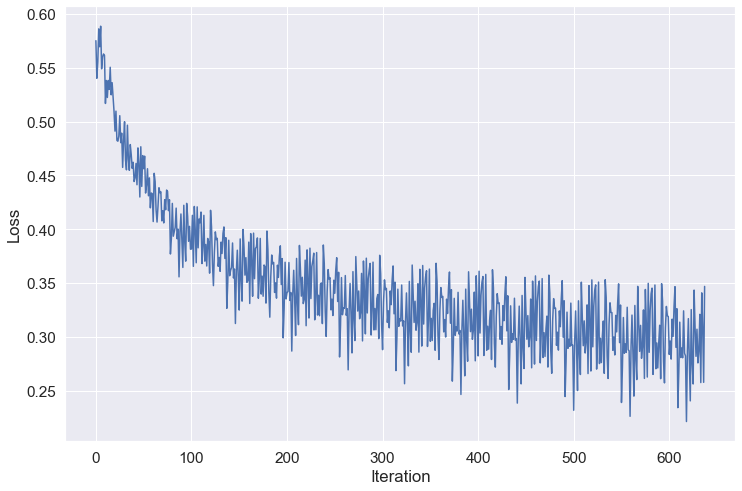

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

torch.Size([100000, 1])
tensor([[ 0.9961],
        [ 0.9679],
        [ 0.9397],
        ...,
        [-1.1174],
        [-1.1456],
        [-1.1739]])


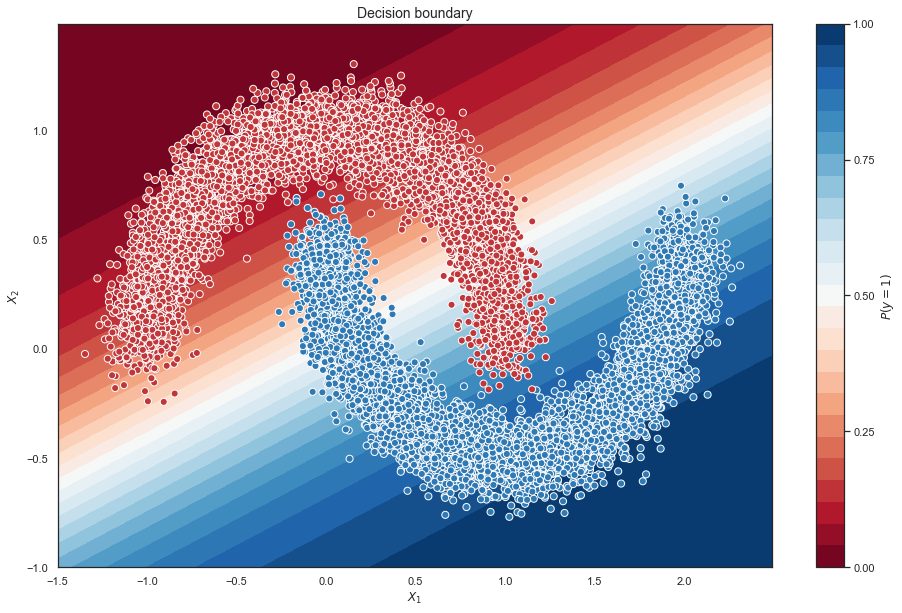

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    outp = model(dataloader)
    probabilities = 1 / (1 + torch.exp(-outp))
    preds = (probabilities > 0.5).type(torch.long)
    predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val_t, predict(X_val_t, linear_regression)))


torch.Size([2500, 1])
tensor([[ 2.6053],
        [ 2.5971],
        [-1.9219],
        ...,
        [ 2.9359],
        [-1.4869],
        [-3.3701]])
0.8692


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8692 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=True, num_workers=2)# YOUR CODE GOES HERE
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=100,
                                         shuffle=False, num_workers=2)# YOUR CODE GOES HERE
print(train_dataloader.dataset.train_data.shape)
valid_dataloader.dataset.train_data.shape


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([10000, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU()
classes = 10
model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(784,128), 
      activation,
      nn.Linear(128,10),
      activation,
      nn.Linear(10, classes)
    ) #YOUR CODE. Add layers to your sequential class


In [ ]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

In [ ]:
#y_batch = y_batch[:, None]
#x = x.view(-1, 6 * 6 * 128)
x_batch.shape, y_batch.shape

(torch.Size([100, 1, 28, 28]), torch.Size([100]))

### Задание. Дополните цикл обучения.

In [ ]:

max_epochs = 10

accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                optimizer.zero_grad()  
                outp = model(x_batch)
               
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch)  
            #count_metrics(outp, y_batch)# YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch).type(torch.long).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()  
                optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
print(accuracy)


Epoch: 1
Loader: train. Accuracy: 0.8600833333333333
Loader: valid. Accuracy: 0.917
Epoch: 2
Loader: train. Accuracy: 0.9354333333333333
Loader: valid. Accuracy: 0.9484
Epoch: 3
Loader: train. Accuracy: 0.9537
Loader: valid. Accuracy: 0.9623
Epoch: 4
Loader: train. Accuracy: 0.9637333333333333
Loader: valid. Accuracy: 0.9652
Epoch: 5
Loader: train. Accuracy: 0.9694666666666667
Loader: valid. Accuracy: 0.9705
Epoch: 6
Loader: train. Accuracy: 0.9731
Loader: valid. Accuracy: 0.9704
Epoch: 7
Loader: train. Accuracy: 0.9772833333333333
Loader: valid. Accuracy: 0.9707
Epoch: 8
Loader: train. Accuracy: 0.9798166666666667
Loader: valid. Accuracy: 0.9714
Epoch: 9
Loader: train. Accuracy: 0.9814833333333334
Loader: valid. Accuracy: 0.9685
Epoch: 10
Loader: train. Accuracy: 0.9833833333333334
Loader: valid. Accuracy: 0.9759
{'train': [0.8600833333333333, 0.9354333333333333, 0.9537, 0.9637333333333333, 0.9694666666666667, 0.9731, 0.9772833333333333, 0.9798166666666667, 0.9814833333333334, 0.98338

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
#elu_accuracy = accuracy["valid"]


In [ ]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    print(activation)
    torch.manual_seed(0)
    classes = 10
    model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128), 
    activation,
    nn.Linear(128,10),
    activation,
    nn.Linear(10, classes)
    )#YOUR CODE. Add layers to your sequential class
    
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10

    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()  
                    optimizer.zero_grad()  
                    outp = model(x_batch)

                     # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                else:
                    model.eval()  
                    with torch.no_grad():  
                        outp = model(x_batch)  
                #count_metrics(outp, y_batch)# YOUR CODE. Set model to ``eval`` mode and calculate outputs
                preds = outp.argmax(-1)
                correct = (preds == y_batch).type(torch.long).sum() # YOUR CODE GOES HERE
                all = y_batch.size(0) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()  
                    optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy#YOUR CODE

In [ ]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())#YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
elu_accuracy = test_activation_function(nn.ELU())#YOUR CODE

Identical()
Epoch: 1
Loader: train. Accuracy: 0.8568
Loader: valid. Accuracy: 0.9041
Epoch: 2
Loader: train. Accuracy: 0.9050833333333334
Loader: valid. Accuracy: 0.9032
Epoch: 3
Loader: train. Accuracy: 0.9100666666666667
Loader: valid. Accuracy: 0.9094
Epoch: 4
Loader: train. Accuracy: 0.9120833333333334
Loader: valid. Accuracy: 0.9198
Epoch: 5
Loader: train. Accuracy: 0.9141166666666667
Loader: valid. Accuracy: 0.9169
Epoch: 6
Loader: train. Accuracy: 0.9152166666666667
Loader: valid. Accuracy: 0.9134
Epoch: 7
Loader: train. Accuracy: 0.9178166666666666
Loader: valid. Accuracy: 0.9165
Epoch: 8
Loader: train. Accuracy: 0.91705
Loader: valid. Accuracy: 0.9098
Epoch: 9
Loader: train. Accuracy: 0.91885
Loader: valid. Accuracy: 0.9176
Epoch: 10
Loader: train. Accuracy: 0.91955
Loader: valid. Accuracy: 0.9192
ReLU()
Epoch: 1
Loader: train. Accuracy: 0.6949666666666666
Loader: valid. Accuracy: 0.8712
Epoch: 2
Loader: train. Accuracy: 0.9038833333333334
Loader: valid. Accuracy: 0.9136
Epoch

In [ ]:
print('plain_accuracy: ',plain_accuracy)
print('elu_accuracy: ', elu_accuracy)
print('relu_accuracy: ', relu_accuracy)
print('leaky_relu_accuracy: ', leaky_relu_accuracy)



plain_accuracy:  {'train': [0.8568, 0.9050833333333334, 0.9100666666666667, 0.9120833333333334, 0.9141166666666667, 0.9152166666666667, 0.9178166666666666, 0.91705, 0.91885, 0.91955], 'valid': [0.9041, 0.9032, 0.9094, 0.9198, 0.9169, 0.9134, 0.9165, 0.9098, 0.9176, 0.9192]}
elu_accuracy:  {'train': [0.8506166666666667, 0.9359666666666666, 0.9541166666666666, 0.96295, 0.9694833333333334, 0.9728166666666667, 0.9772666666666666, 0.9785, 0.9814333333333334, 0.98325], 'valid': [0.9157, 0.9431, 0.9593, 0.9623, 0.9693, 0.9683, 0.9706, 0.9673, 0.9687, 0.9749]}
relu_accuracy:  {'train': [0.6949666666666666, 0.9038833333333334, 0.9299666666666667, 0.9431833333333334, 0.9517333333333333, 0.9561, 0.9613333333333334, 0.9641333333333333, 0.9667666666666667, 0.9686333333333333], 'valid': [0.8712, 0.9136, 0.9393, 0.9437, 0.9523, 0.9538, 0.9594, 0.9612, 0.9639, 0.965]}
leaky_relu_accuracy:  {'train': [0.7923166666666667, 0.9216833333333333, 0.9410333333333334, 0.9523166666666667, 0.9599, 0.9641, 0.9676

In [ ]:
plain_accuracy1 = plain_accuracy['valid']
relu_accuracy1 = relu_accuracy['valid']
leaky_relu_accuracy1 = leaky_relu_accuracy['valid']
elu_accuracy1 = elu_accuracy['valid']

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

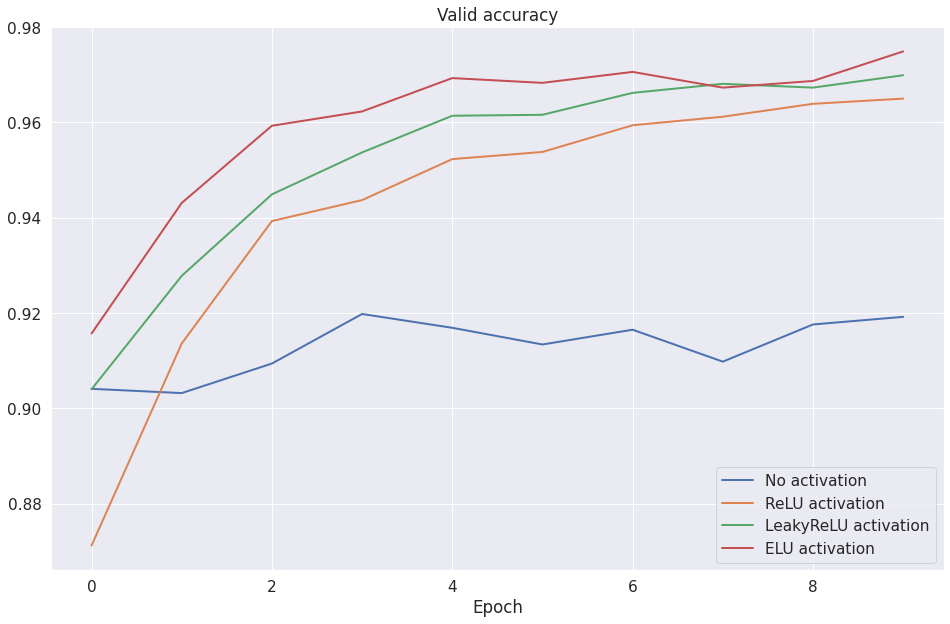

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy1, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy1, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy1, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy1, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

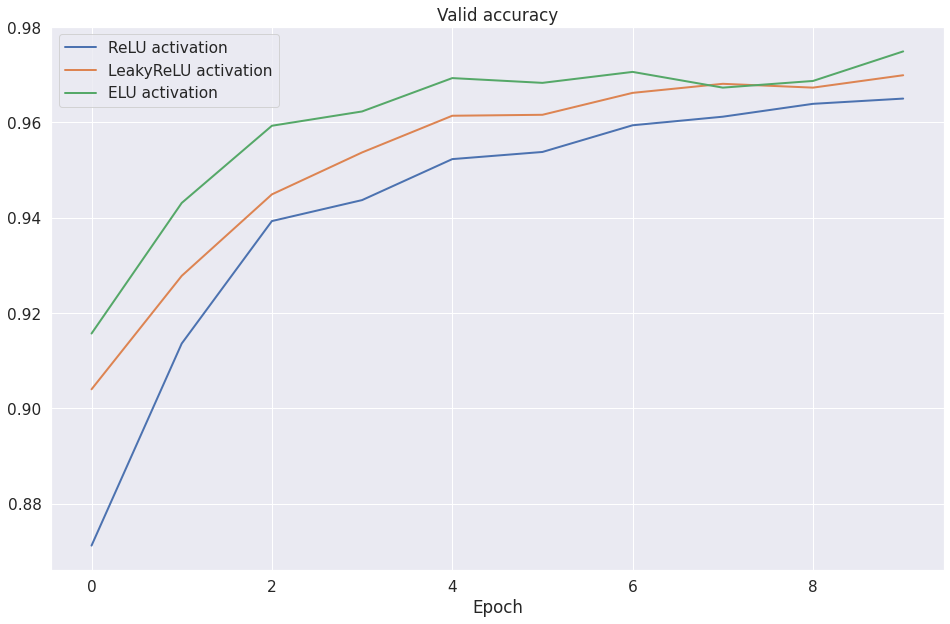

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy1, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy1, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy1, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU-лучший результат. чуть хуже LeakyReLU.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
#!pip install wget
#import wget

!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-12-06 16:16:11--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-12-06 16:16:11--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   134KB/s    in 0.4s    

2021-12-06 16:16:12 (134 KB/s) - ‘sample_photo.jpg’ saved [49337/4

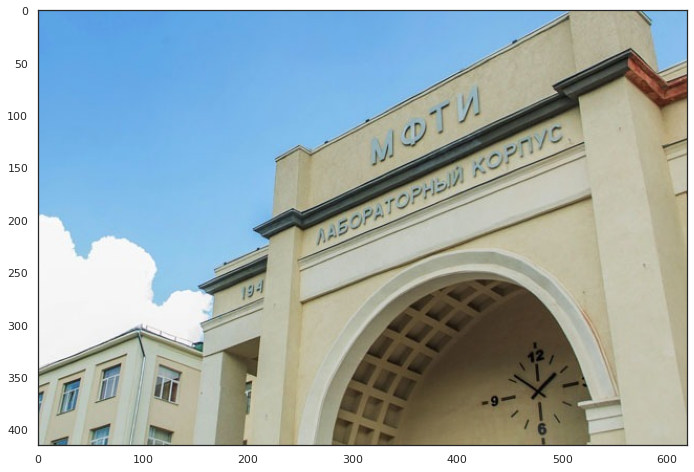

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

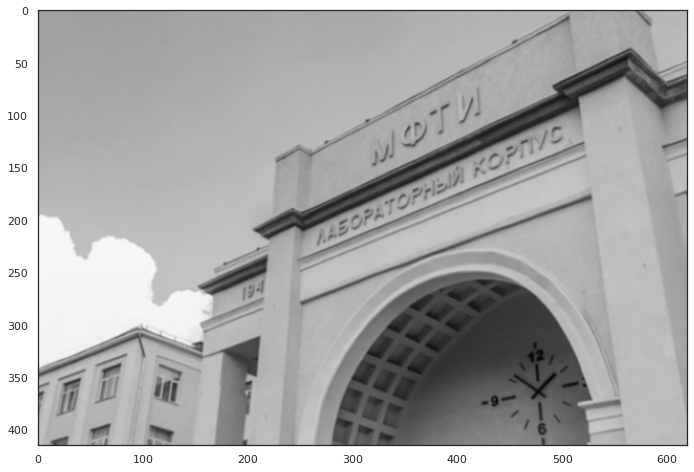

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие - Е

2) Увеличение резкости -Д

3) Тождественное преобразование -А

4) Выделение вертикальных границ -В

5) Выделение горизонтальных границ -Б

6) Выделение границ -Г

**Ответ:** 

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2)#YOUR CODE
        self.conv2 = nn.Conv2d(6, 16, 3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(2)#YOUR CODE
        self.fc1 = nn.Linear(5 * 5 * 16, 120)#YOUR CODE  
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__. 
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x)
        x = x.view(-1, 5 * 5 * 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10

accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()  
                optimizer.zero_grad()  
                outp = model(x_batch)
               
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()  
                with torch.no_grad():  
                    outp = model(x_batch)  
            #count_metrics(outp, y_batch)# YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct = (preds == y_batch).type(torch.long).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()  
                optimizer.step()# YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
print(accuracy)#<YOUR CODE>

Epoch: 1
Loader: train. Accuracy: 0.8849
Loader: valid. Accuracy: 0.966
Epoch: 2
Loader: train. Accuracy: 0.9700833333333333
Loader: valid. Accuracy: 0.9786
Epoch: 3
Loader: train. Accuracy: 0.9802
Loader: valid. Accuracy: 0.9844
Epoch: 4
Loader: train. Accuracy: 0.98405
Loader: valid. Accuracy: 0.9816
Epoch: 5
Loader: train. Accuracy: 0.9867666666666667
Loader: valid. Accuracy: 0.9859
Epoch: 6
Loader: train. Accuracy: 0.9891666666666666
Loader: valid. Accuracy: 0.9865
Epoch: 7
Loader: train. Accuracy: 0.9898333333333333
Loader: valid. Accuracy: 0.9871
Epoch: 8
Loader: train. Accuracy: 0.9911666666666666
Loader: valid. Accuracy: 0.9873
Epoch: 9
Loader: train. Accuracy: 0.9929166666666667
Loader: valid. Accuracy: 0.9876
Epoch: 10
Loader: train. Accuracy: 0.9929333333333333
Loader: valid. Accuracy: 0.9878
{'train': [0.8849, 0.9700833333333333, 0.9802, 0.98405, 0.9867666666666667, 0.9891666666666666, 0.9898333333333333, 0.9911666666666666, 0.9929166666666667, 0.9929333333333333], 'valid':

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

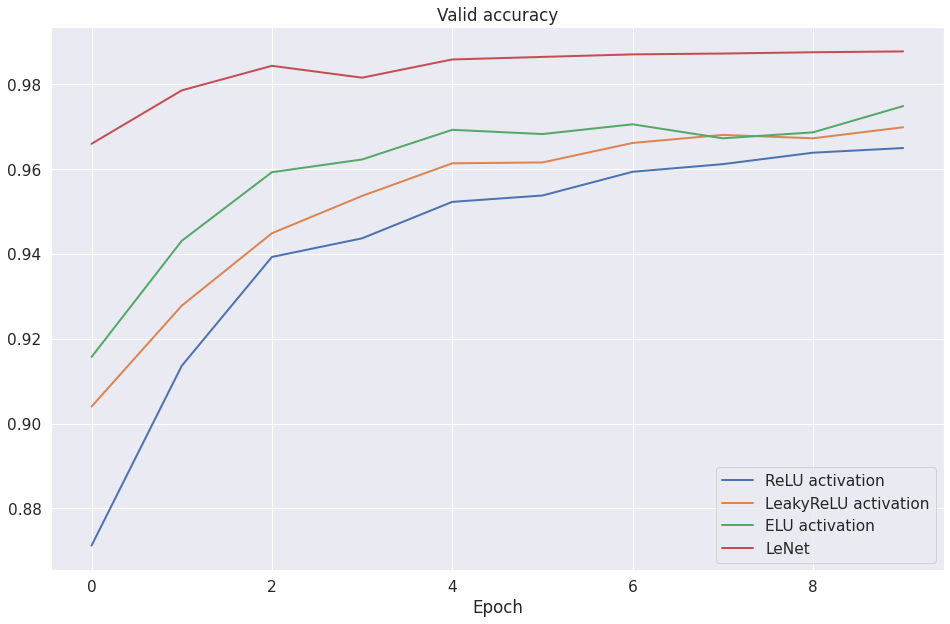

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy1, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy1, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy1, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,99